In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import cvxopt
import pyreadr
import os
import time
from datetime import timedelta
from scipy.stats import norm
import copy
import warnings
import utils
import regression_fit
import pickle
from importlib import reload
reload(utils)
reload(regression_fit)
from utils import *
from regression_fit import *

home = os.getcwd()

# Group C

## Dataset preprocessing
Train set: from 2014 to 2018. Test set: from 2019 to 2021

In [8]:
# Import dataset of group C
GroupC = pyreadr.read_r(home + '\\Other_data\\GroupC.rda')
GroupC_df = pd.DataFrame(list(GroupC.values())[0])

# Add lagged net-load values (columns y0_96, y0_336, diff_96, diff_336)
GroupC_df = add_autoregressive_features(GroupC_df)

# Split in train and test set 
# 
train_set = GroupC_df[720:87440] 
test_set = GroupC_df[87440:]

### Summary statistics on train set

In [10]:
GroupC_df["node"][:87440].describe()

count    87440.000000
mean      1643.772359
std        375.144365
min        911.902000
25%       1319.770500
50%       1665.269500
75%       1928.011750
max       2679.683000
Name: node, dtype: float64

### Seasonality plots on different scales

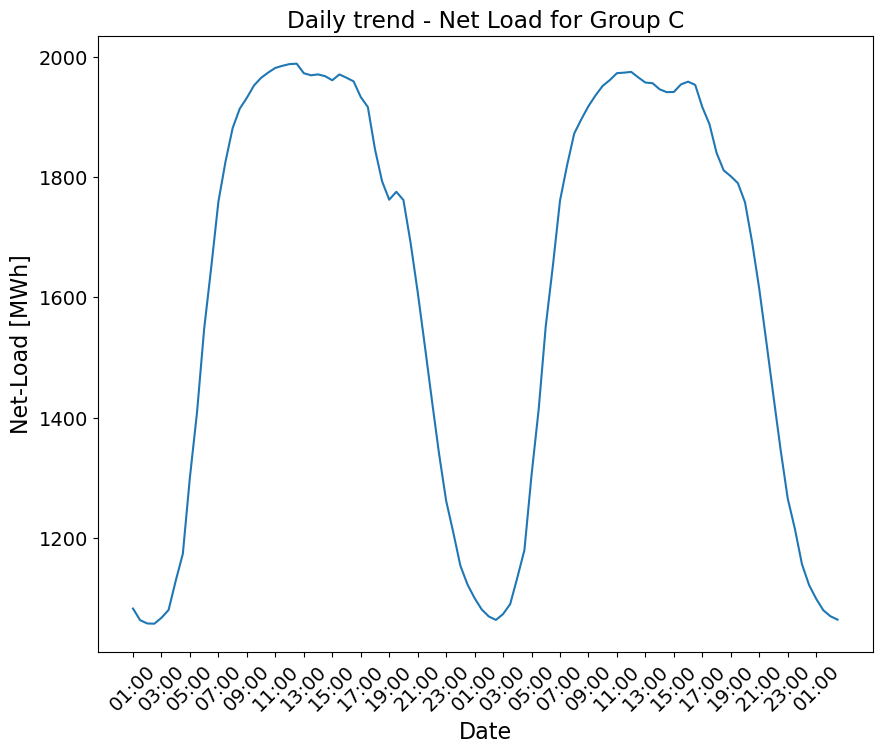

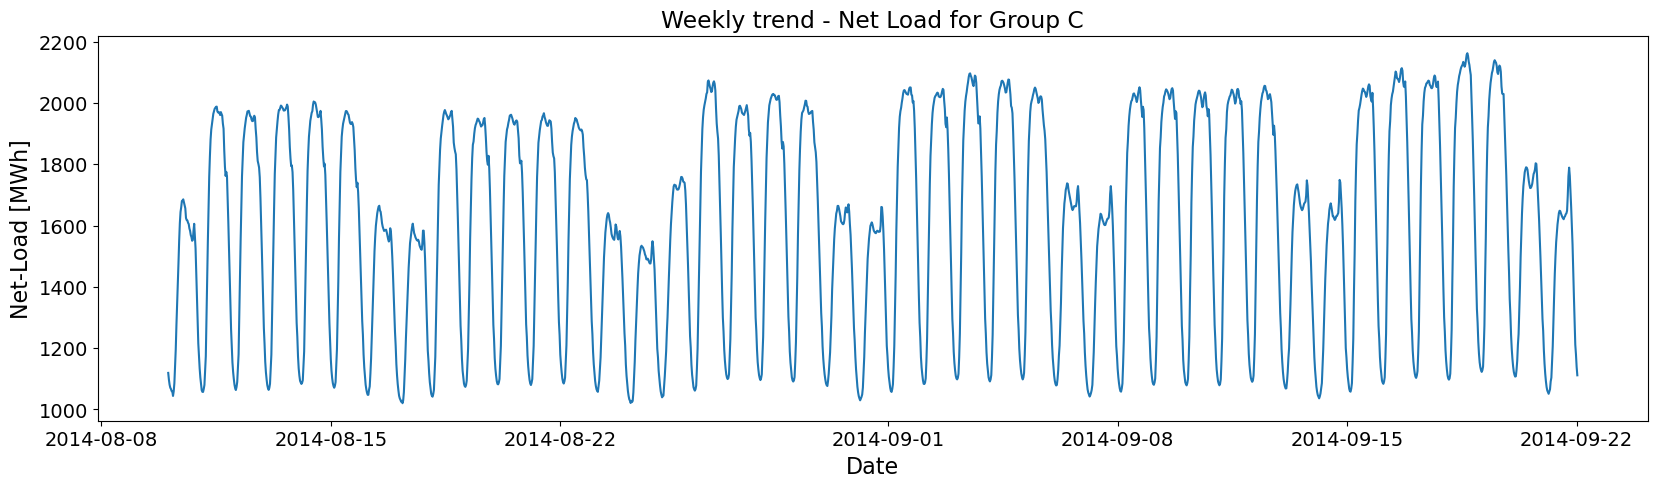

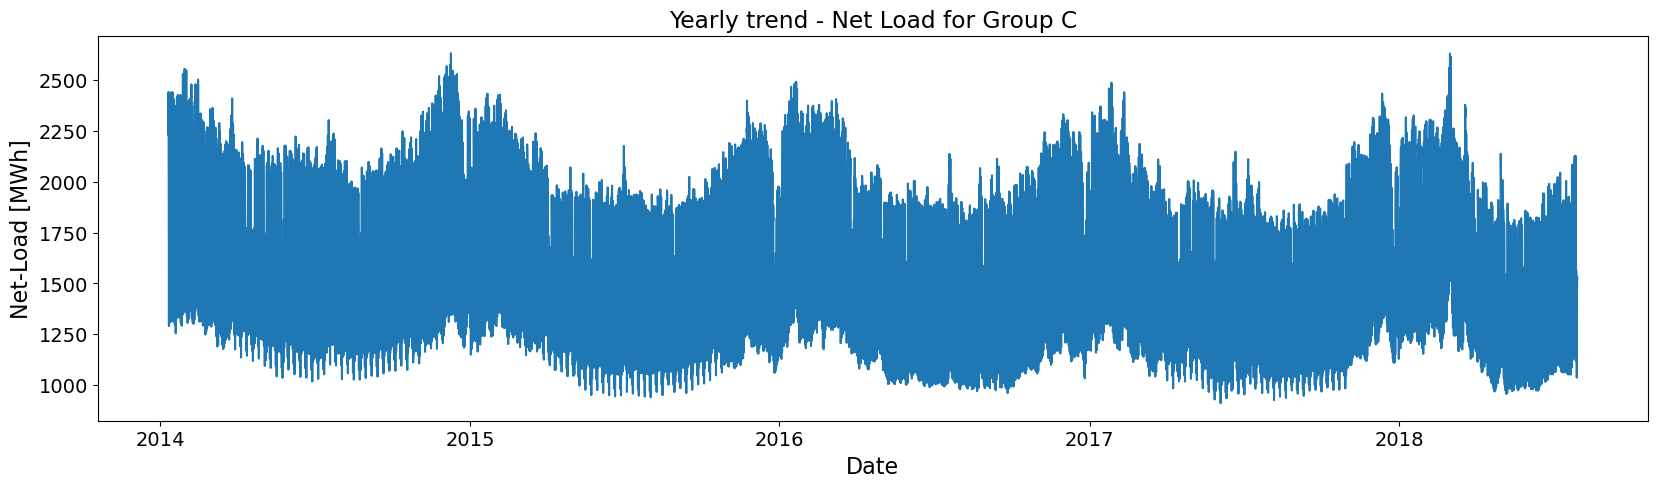

In [12]:
# Daily trend - Net Load for Group C 
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(GroupC_df["targetTime"][10466:10566], GroupC_df["node"][10466:10566], '-')
plt.xticks(GroupC_df["targetTime"][10466:10566][::4], [date.strftime('%H:%M') for date in GroupC_df['targetTime'][10466:10566][::4]])
plt.xticks(rotation=45)
plt.title("Daily trend - Net Load for Group C");
plt.xlabel("Date", fontsize=16);
plt.ylabel("Net-Load [MWh]", fontsize=16);
#plt.savefig("Figures/dailyC.jpg")

# Weekly trend - Net Load for Group C 
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][10418:12482], GroupC_df["node"][10418:12482])
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net-Load [MWh]", fontsize=16);
plt.title("Weekly trend - Net Load for Group C");
#fig.savefig("Figures/weeklyC.jpg")

# Yearly trend - Net Load for Group C
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][400:80000:8], GroupC_df["node"][400:80000:8])
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net-Load [MWh]", fontsize=16);
plt.title("Yearly trend - Net Load for Group C");
#fig.savefig("Figures/yearlyC.jpg")

# Autocorrelation

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\4113361503.py:6: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\4113361503.py:13: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')


Text(0.5, 1.0, 'Partial Autocorrelation function of Net-Load Group C')

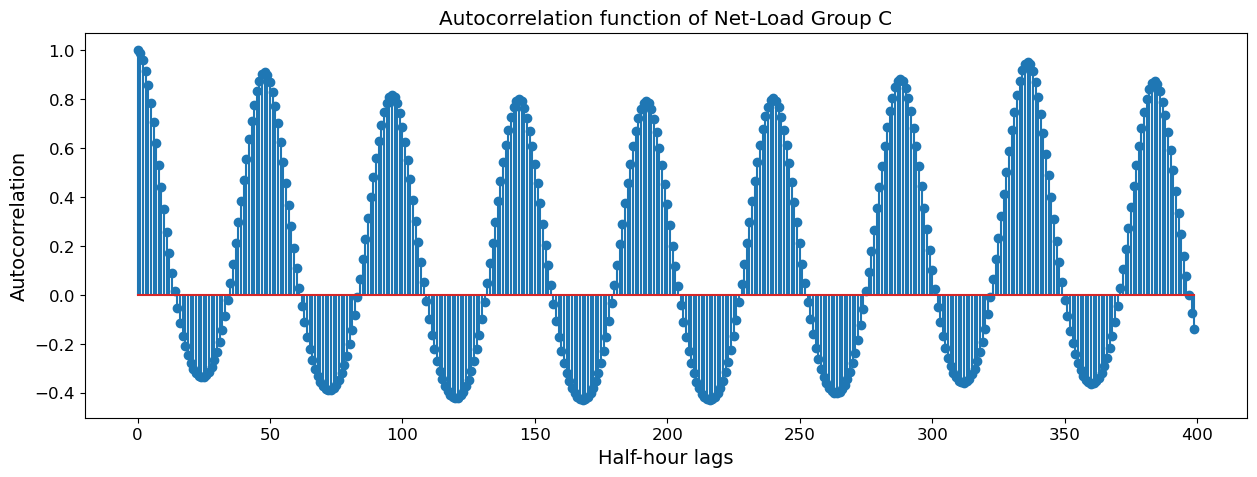

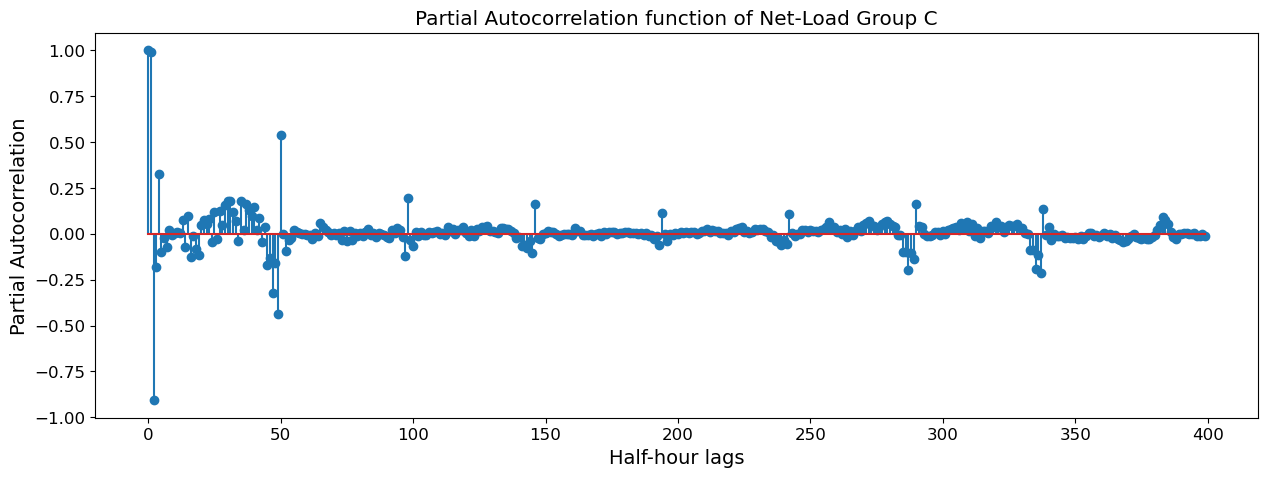

In [14]:
from statsmodels.tsa.stattools import pacf, acf

plt.figure(figsize=(15,5))

plt.rcParams.update({'font.size': 12})
plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Autocorrelation", fontsize=14);
plt.title("Autocorrelation function of Net-Load Group C")
#plt.savefig("Figures/AutocorrC.jpg")

plt.figure(figsize=(15,5))
plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Partial Autocorrelation", fontsize=14);
plt.title("Partial Autocorrelation function of Net-Load Group C")
#plt.savefig("Figures/PartialAutocorrC.jpg")

# ADF test 

p-values of the ADF test for the 336 sub-series (one for each 30 minutes in 7 days) and of their differenced sub-series

In [17]:
p_value_336 = []
p_value_336_diff = []
for t in range(336):
    res = adfuller(np.array(train_set['node'])[t+144::336],regression='c',regresults=True)
    p_value_336.append(res[1])    
    y_336 = np.array(train_set['node'])[t+144::336]
    y_diff = y_336[1:]-y_336[:-1]
    res = adfuller(y_diff,regression='c',regresults=True)
    p_value_336_diff.append(res[1])


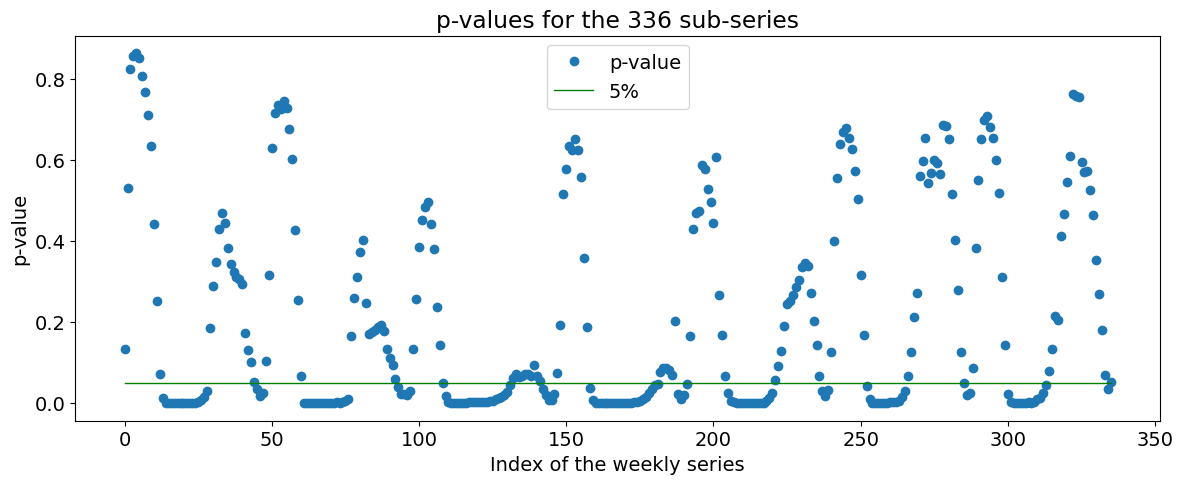

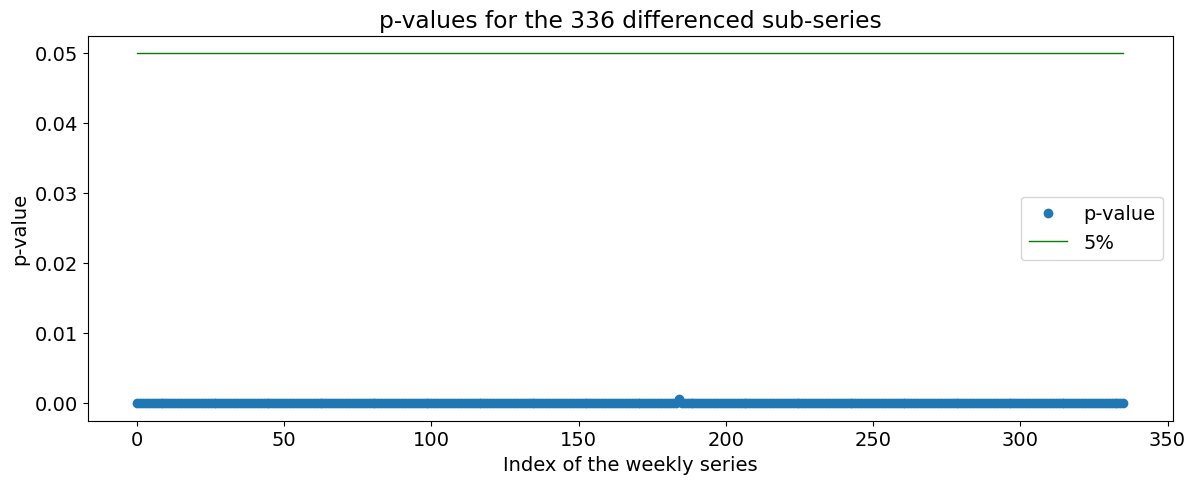

In [18]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_C.jpg")

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336_diff, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 differenced sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_7d_C.jpg")

# Autocorrelation differenced net-load time series 

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\2811228227.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\2811228227.py:10: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')


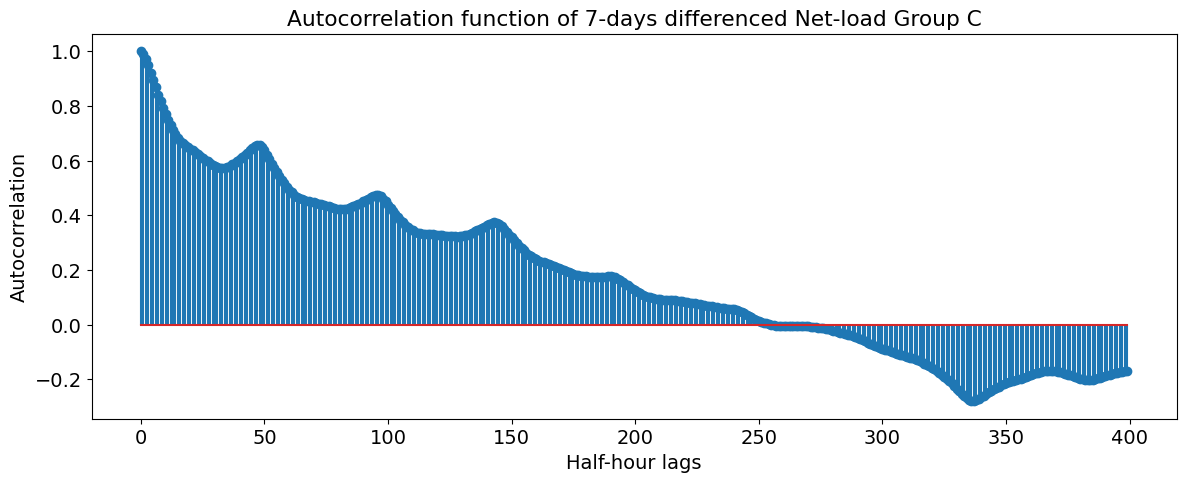

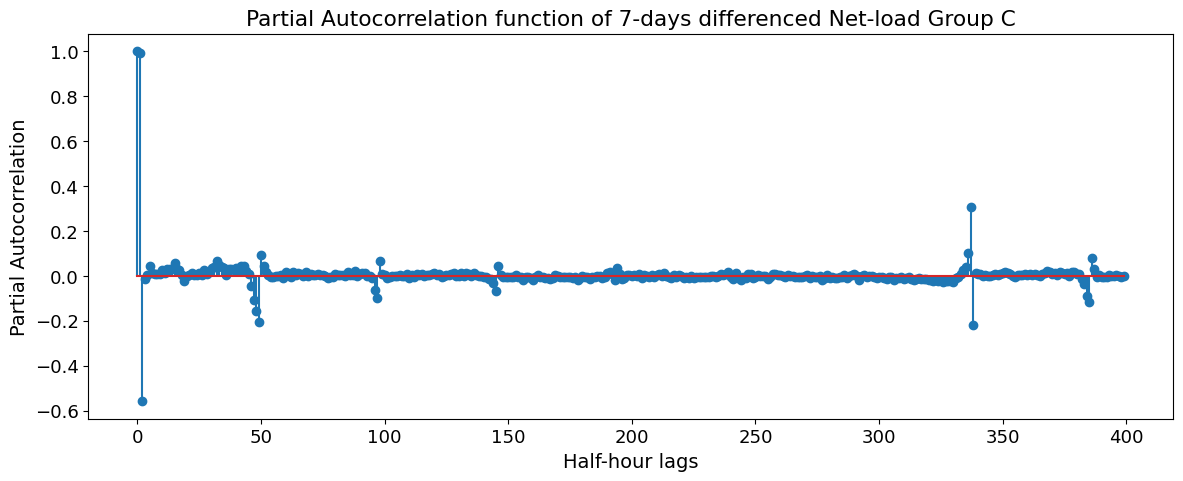

In [20]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.rcParams.update({'font.size': 13})
plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
plt.title('Autocorrelation function of 7-days differenced Net-load Group C');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Autocorrelation", fontsize=14);
#plt.savefig("Figures/AutocorrC_7diff.jpg")

fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')
plt.title('Partial Autocorrelation function of 7-days differenced Net-load Group C');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Partial Autocorrelation", fontsize=14);
#plt.savefig("Figures/PartialAutocorrC_7diff.jpg")

# 7-days differenced net-load time series

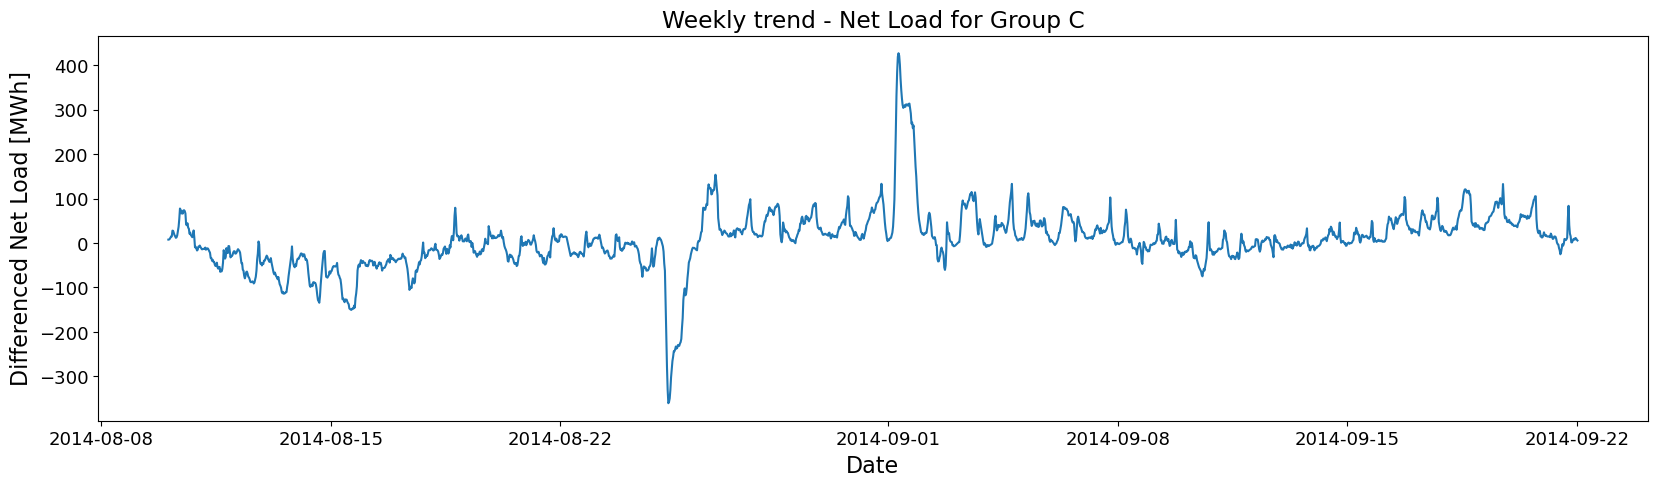

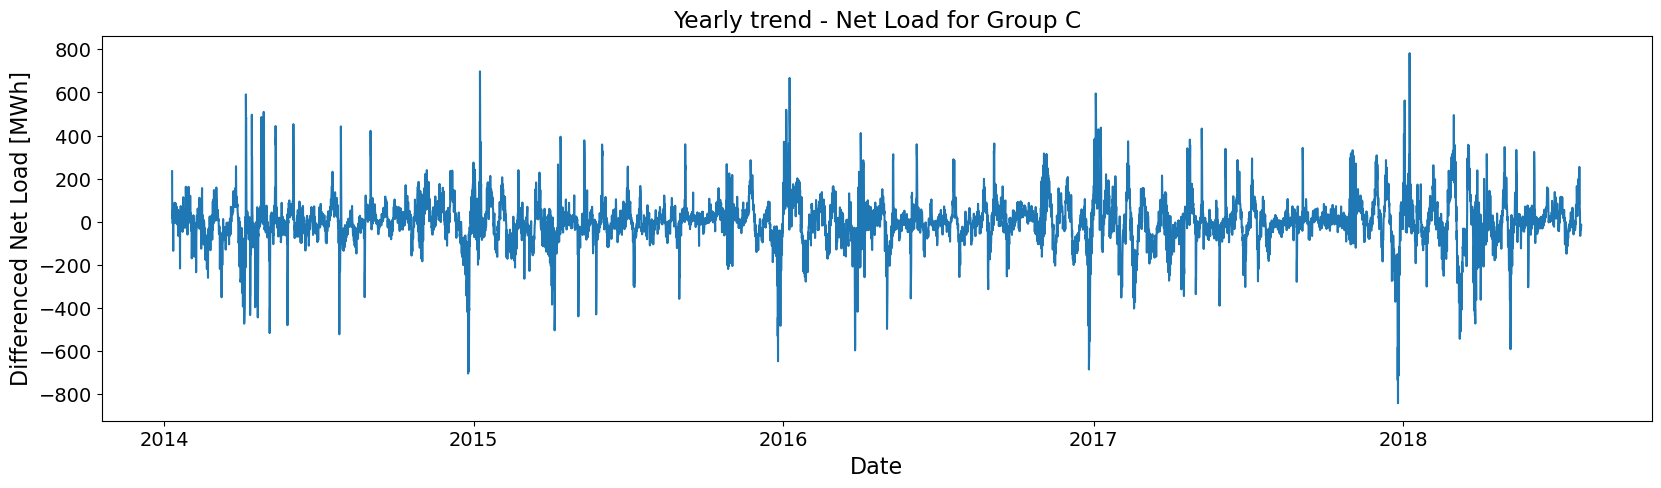

In [22]:
fig, axs = plt.subplots(1,1, figsize=(20,5))

plt.rcParams.update({'font.size': 14})
axs.plot(GroupC_df["targetTime"][10418:12482], GroupC_df["diff_336"][10418:12482])
axs.set_title("Weekly trend - Net Load for Group C")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_weeklyC.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupC_df["targetTime"][400:80000:8], GroupC_df["diff_336"][400:80000:8])

axs.set_title("Yearly trend - Net Load for Group C")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_yearlyC.jpg")

# Group P

## Dataset preprocessing
Train set: from 2014 to 2018. Test set: from 2019 to 2021

In [25]:
# Import dataset of group P
GroupP = pyreadr.read_r(home + '\\Other_data\\GroupP.rda')
GroupP_df = pd.DataFrame(list(GroupP.values())[0])

# Add lagged net-load values (columns y0_96, y0_336, diff_96, diff_336)
GroupP_df = add_autoregressive_features(GroupP_df)

# Split in train and test set 
train_set = GroupP_df[720:87440] 
test_set = GroupP_df[87440:]

### Summary statistics on train set

In [27]:
GroupP_df["node"][:87440].describe()

count    87440.000000
mean        73.486600
std        188.846697
min       -601.742000
25%        -56.414500
50%        105.088500
75%        218.434750
max        554.150000
Name: node, dtype: float64

### Seasonality plots on different scales

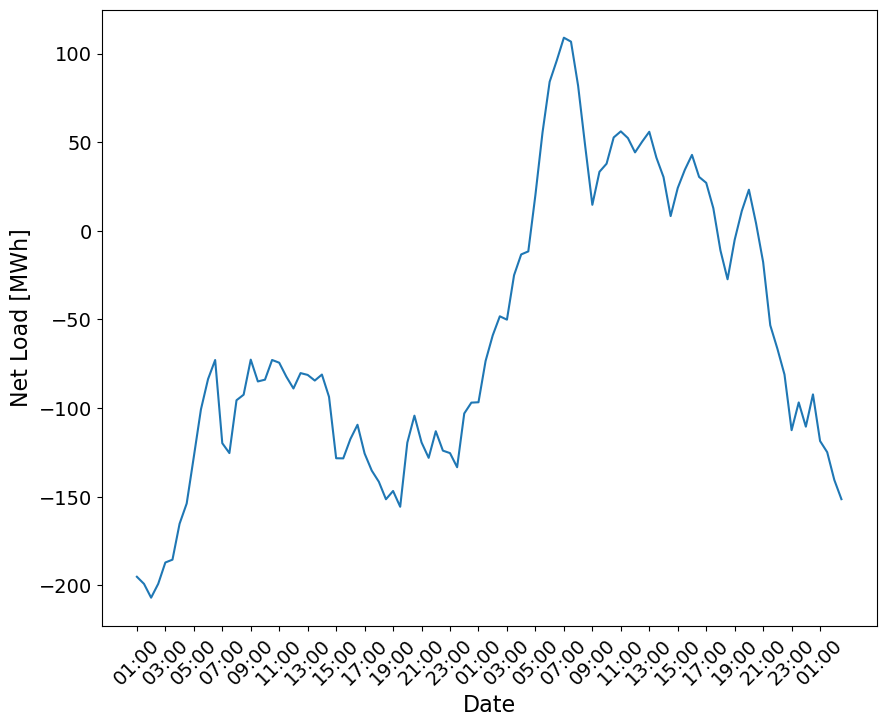

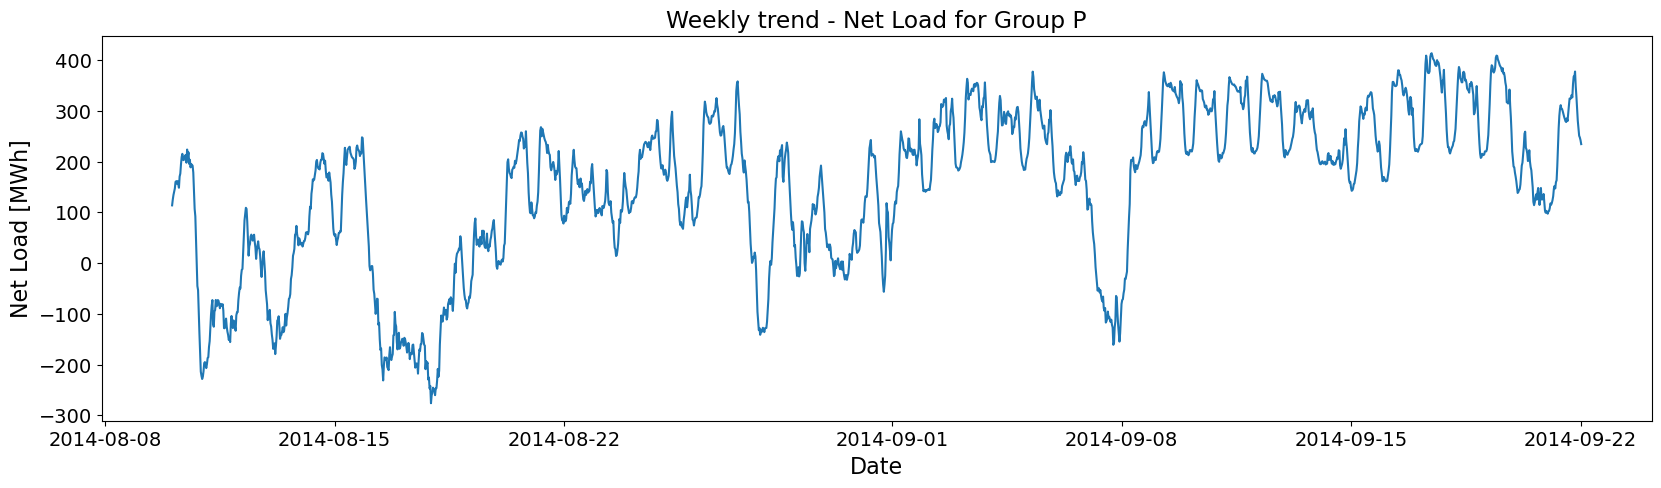

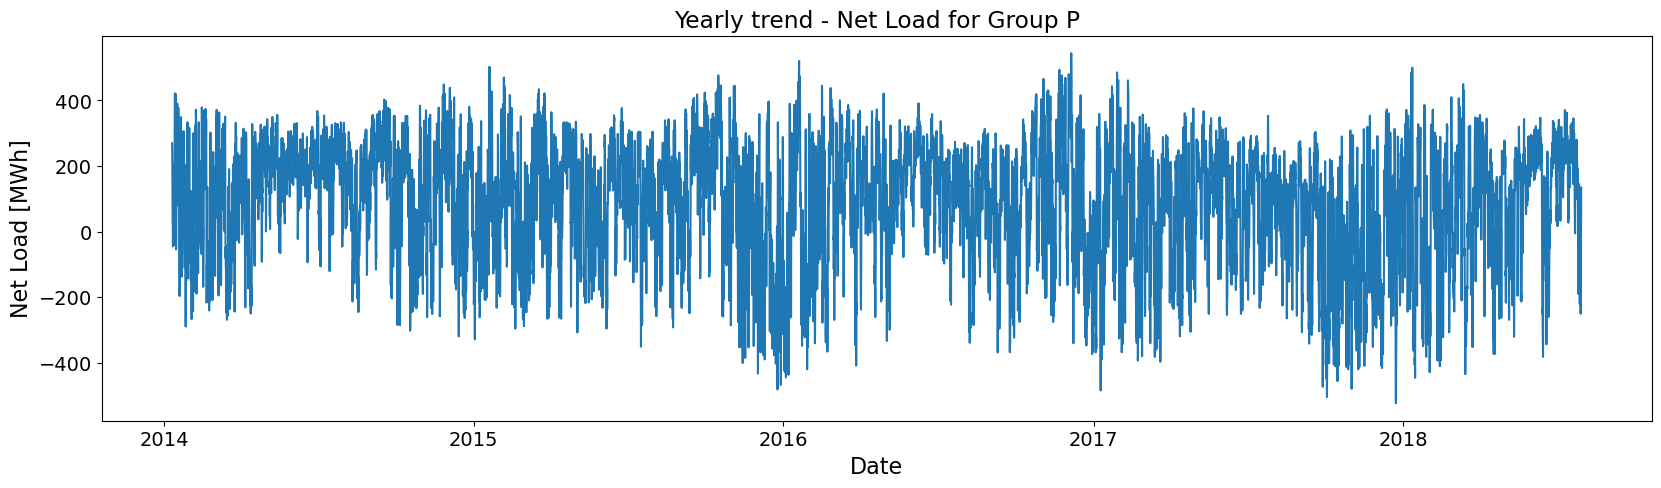

In [29]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,8))
plt.plot(GroupP_df["targetTime"][10466:10566], GroupP_df["node"][10466:10566], '-')
axs.set_title("Daily trend - Net Load for Group P")
plt.xticks(GroupP_df["targetTime"][10466:10566][::4], [date.strftime('%H:%M') for date in GroupP_df['targetTime'][10466:10566][::4]])
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=16);
plt.ylabel("Net Load [MWh]", fontsize=16);
#plt.savefig("Figures/dailyP.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][10418:12482], GroupP_df["node"][10418:12482])
axs.set_title("Weekly trend - Net Load for Group P")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/weeklyP.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][400:80000:8], GroupP_df["node"][400:80000:8])

axs.set_title("Yearly trend - Net Load for Group P")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/yearlyP.jpg")

# Autocorrelation

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\4235761472.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\4235761472.py:11: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')


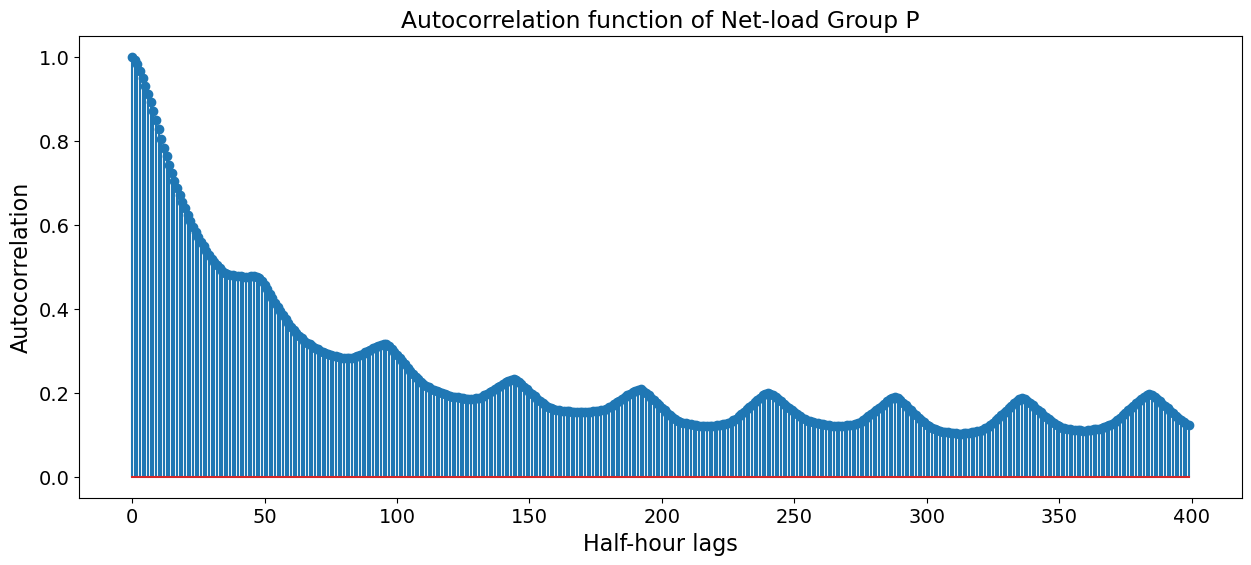

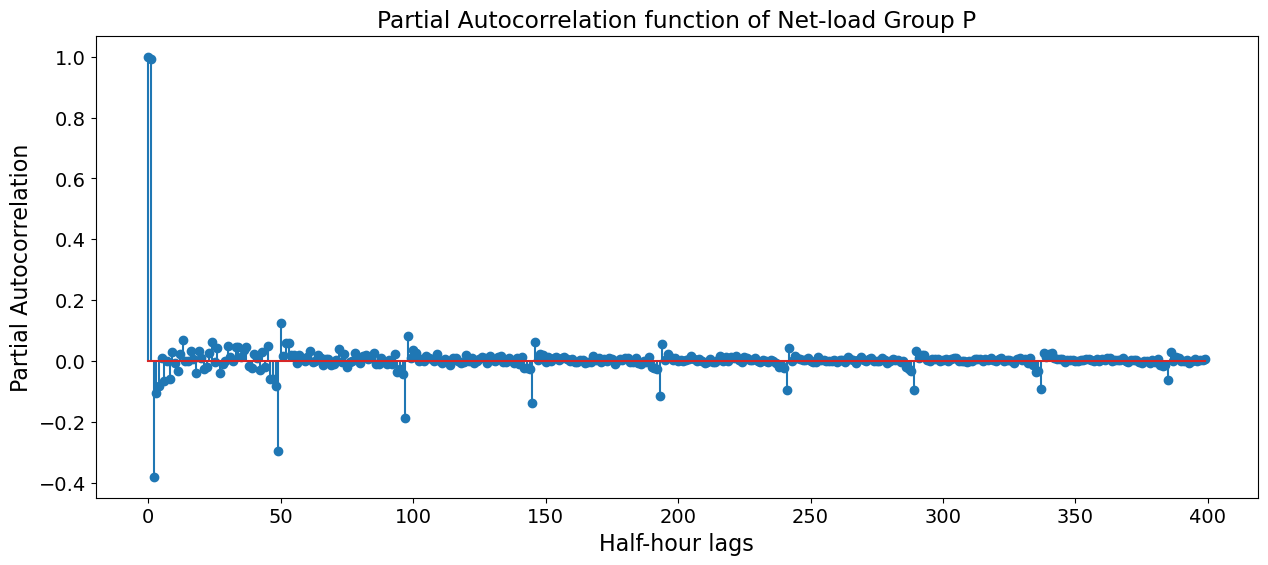

In [31]:
from statsmodels.tsa.stattools import pacf, acf
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,6))
plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
plt.title('Autocorrelation function of Net-load Group P');
plt.xlabel("Half-hour lags", fontsize=16);
plt.ylabel("Autocorrelation", fontsize=16);
#plt.savefig("Figures/AutocorrP.jpg")

plt.figure(figsize=(15,6))
plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')
plt.title('Partial Autocorrelation function of Net-load Group P');
plt.xlabel("Half-hour lags", fontsize=16);
plt.ylabel("Partial Autocorrelation", fontsize=16);
#plt.savefig("Figures/PartialAutocorrP.jpg")

# ADF test 

p-values of the ADF test for the 336 sub-series (one for each 30 minutes in 7 days) and of their differenced sub-series

In [34]:
p_value_336 = []
p_value_336_diff = []
for t in range(336):
    res = adfuller(np.array(train_set['node'])[t+144::336],regression='c',regresults=True)
    p_value_336.append(res[1])    
    y_336 = np.array(train_set['node'])[t+144::336]
    y_diff = y_336[1:]-y_336[:-1]
    res = adfuller(y_diff,regression='c',regresults=True)
    p_value_336_diff.append(res[1])


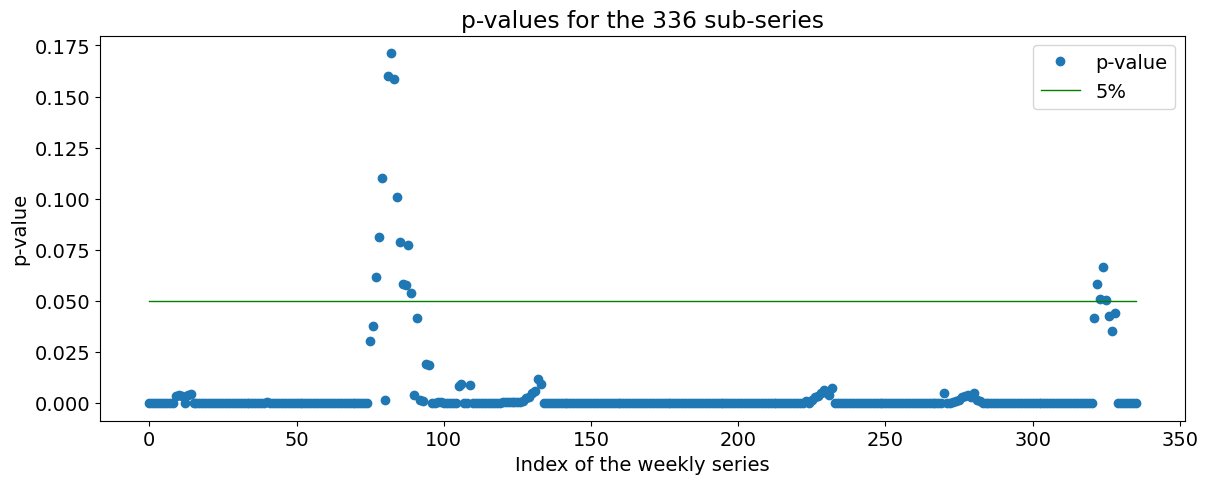

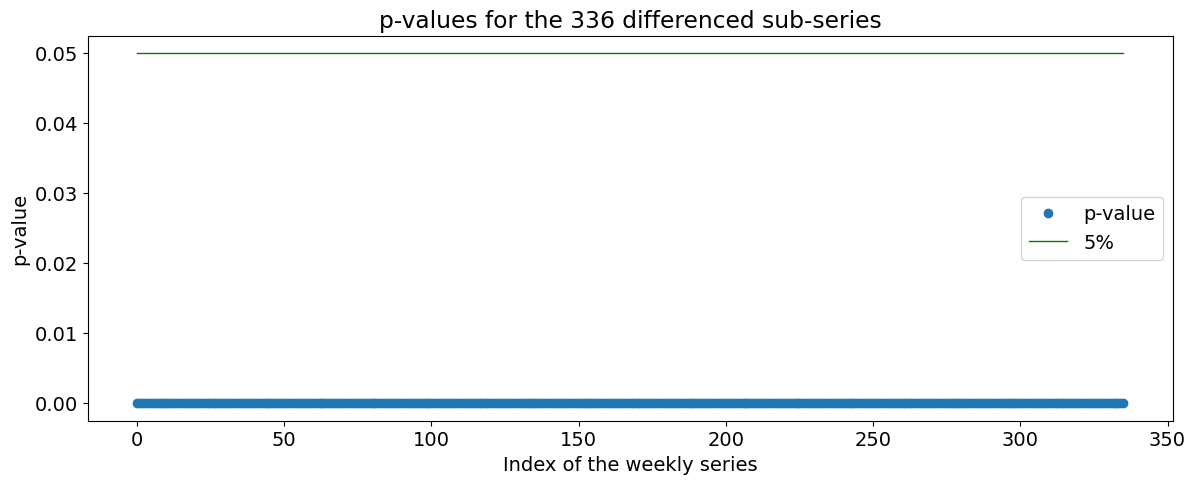

In [35]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_P.jpg")

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336_diff, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 differenced sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_7d_P.jpg")

# Autocorrelation differenced net-load time series 

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\3470126484.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\3470126484.py:10: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')


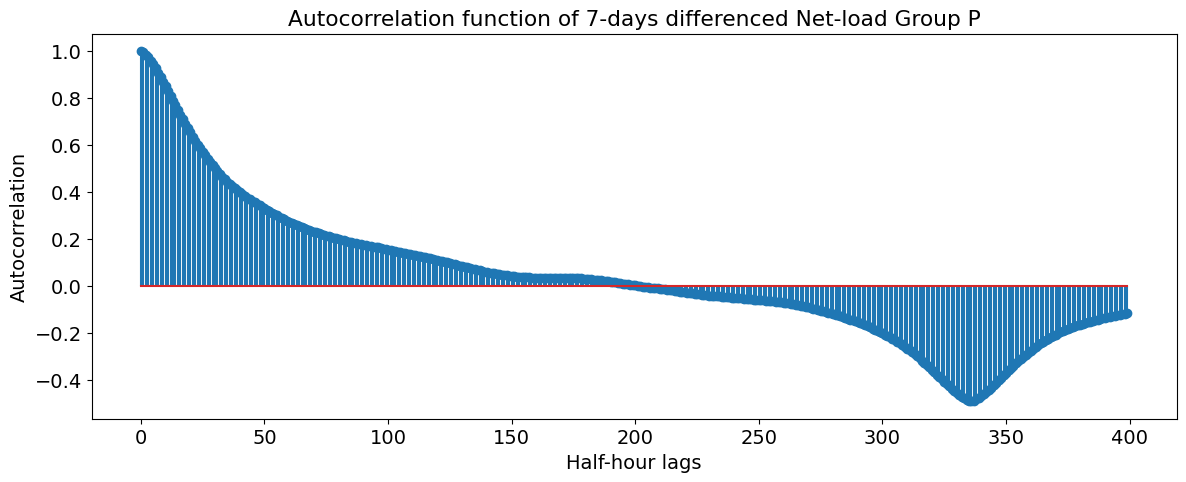

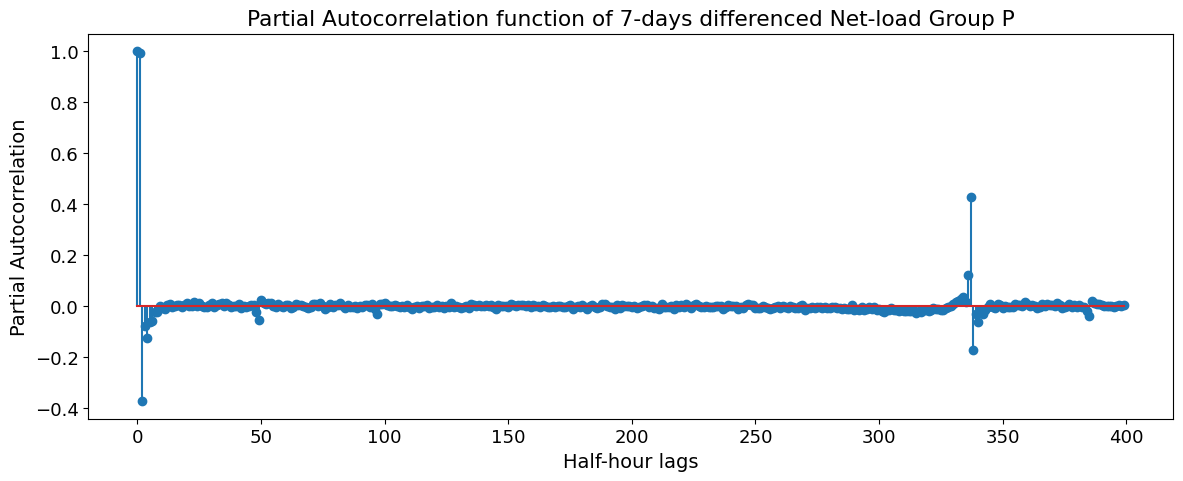

In [37]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.rcParams.update({'font.size': 13})
plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
plt.title('Autocorrelation function of 7-days differenced Net-load Group P');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Autocorrelation", fontsize=14);
#plt.savefig("Figures/AutocorrP_7diff.jpg")

fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')
plt.title('Partial Autocorrelation function of 7-days differenced Net-load Group P');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Partial Autocorrelation", fontsize=14);
#plt.savefig("Figures/PartialAutocorrP_7diff.jpg")

# 7-days differenced net-load time series

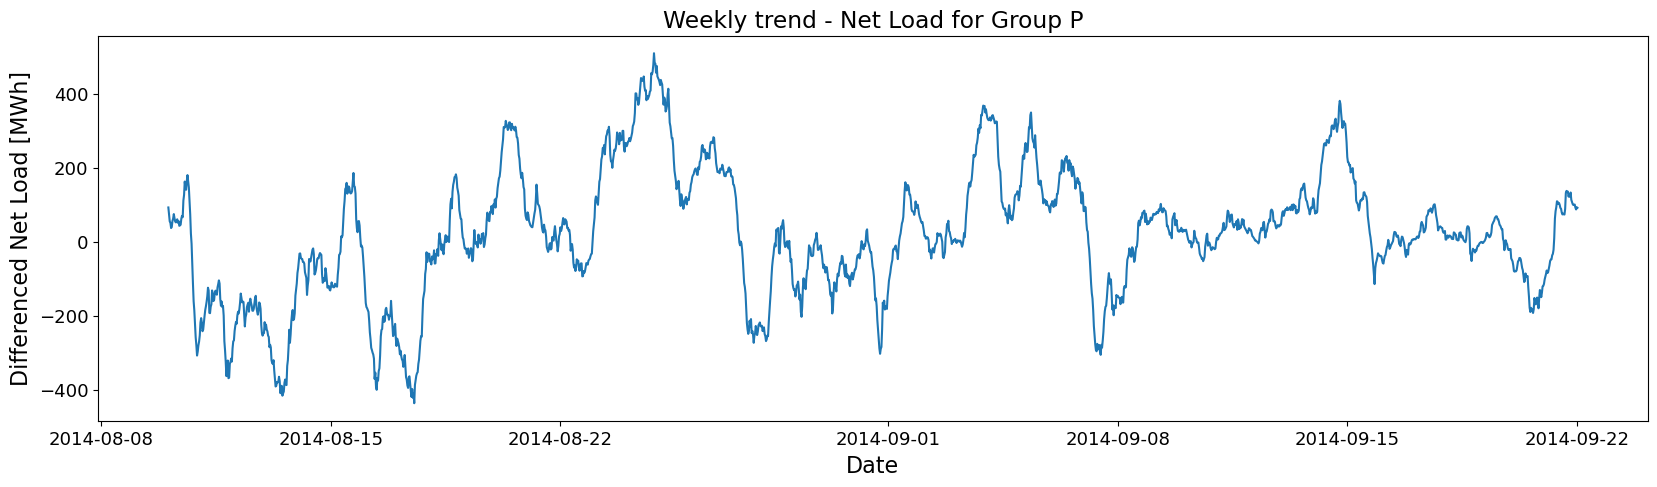

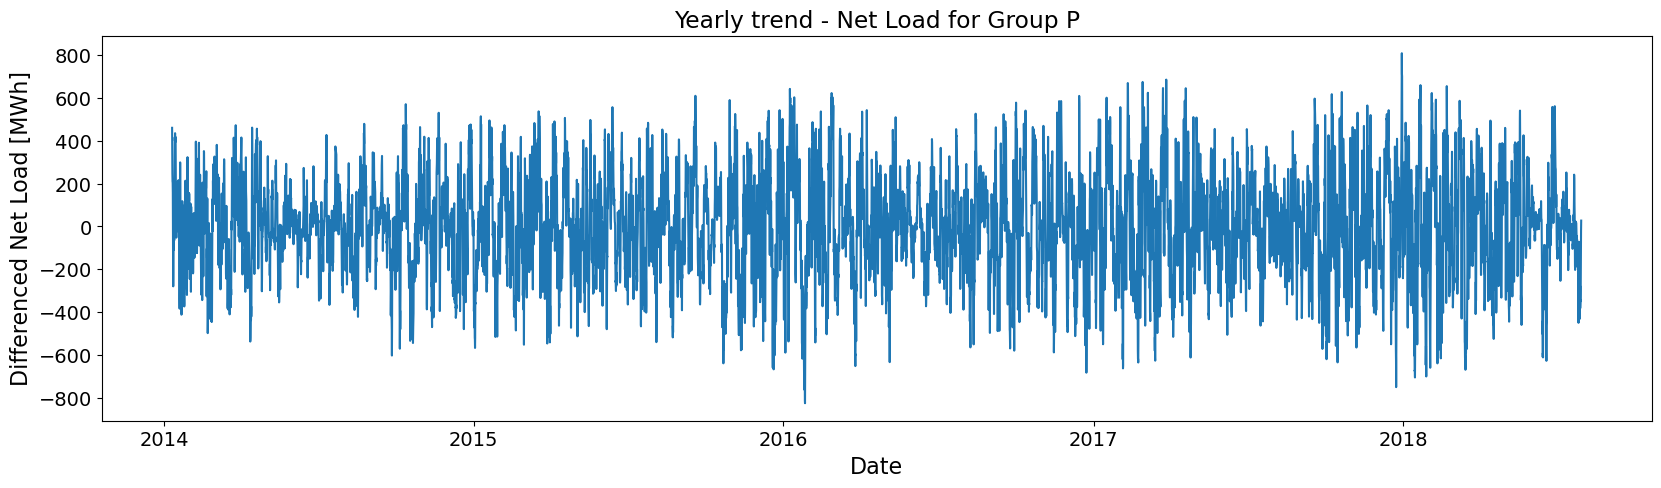

In [39]:
fig, axs = plt.subplots(1,1, figsize=(20,5))

plt.rcParams.update({'font.size': 14})
axs.plot(GroupP_df["targetTime"][10418:12482], GroupP_df["diff_336"][10418:12482])
axs.set_title("Weekly trend - Net Load for Group P")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_weeklyP.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupP_df["targetTime"][400:80000:8], GroupP_df["diff_336"][400:80000:8])

axs.set_title("Yearly trend - Net Load for Group P")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_yearlyP.jpg")

# Group H

## Dataset preprocessing
Train set: from 2014 to 2018. Test set: from 2019 to 2021

In [42]:
# Import dataset of group C
GroupH = pyreadr.read_r(home + '\\Other_data\\GroupH.rda')
GroupH_df = pd.DataFrame(list(GroupH.values())[0])

# Add lagged net-load values (columns y0_96, y0_336, diff_96, diff_336)
GroupH_df = add_autoregressive_features(GroupH_df)

# Split in train and test set  
train_set = GroupH_df[720:87440] 
test_set = GroupH_df[87440:]

### Summary statistics on train set

In [44]:
GroupH_df["node"][:87440].describe()

count    87440.000000
mean      1674.273580
std        393.263651
min        735.755000
25%       1369.256000
50%       1638.547000
75%       1941.487250
max       2927.830000
Name: node, dtype: float64

### Seasonality plots on different scales

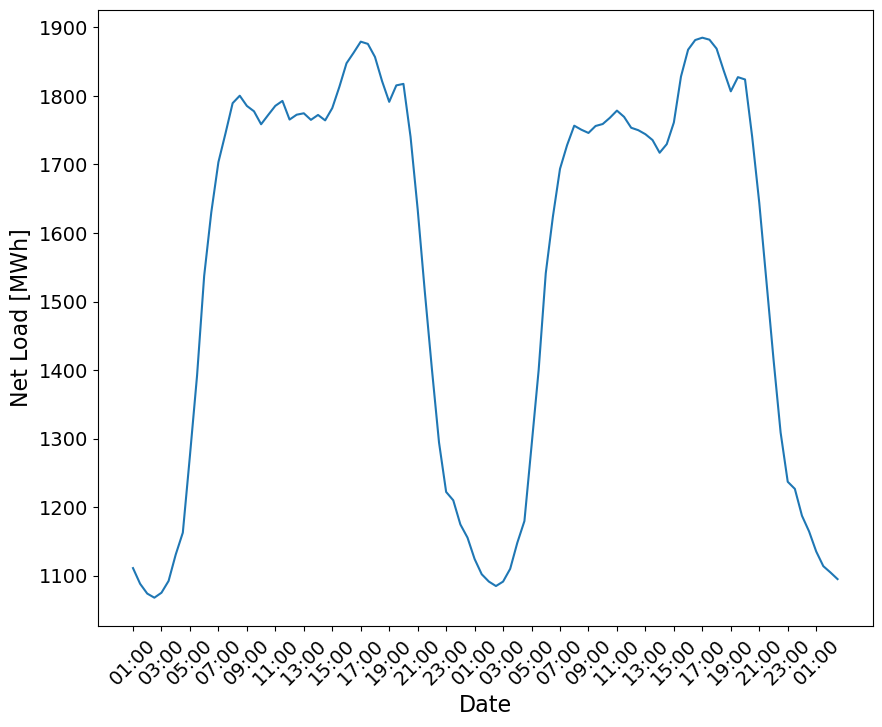

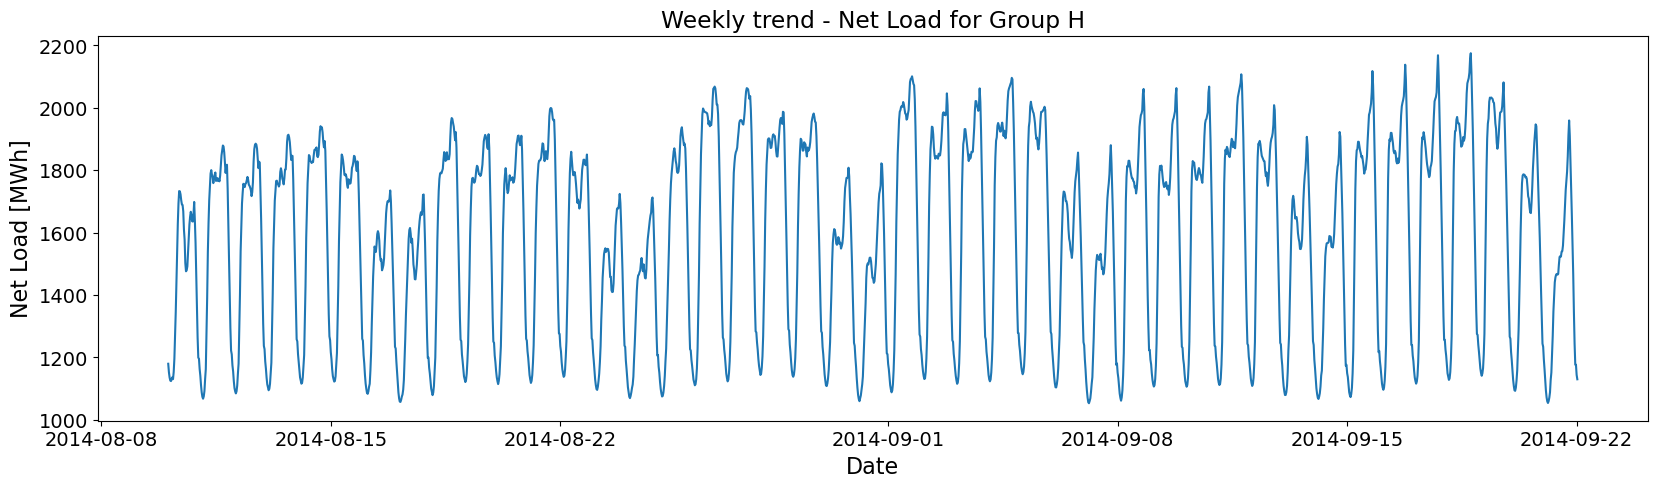

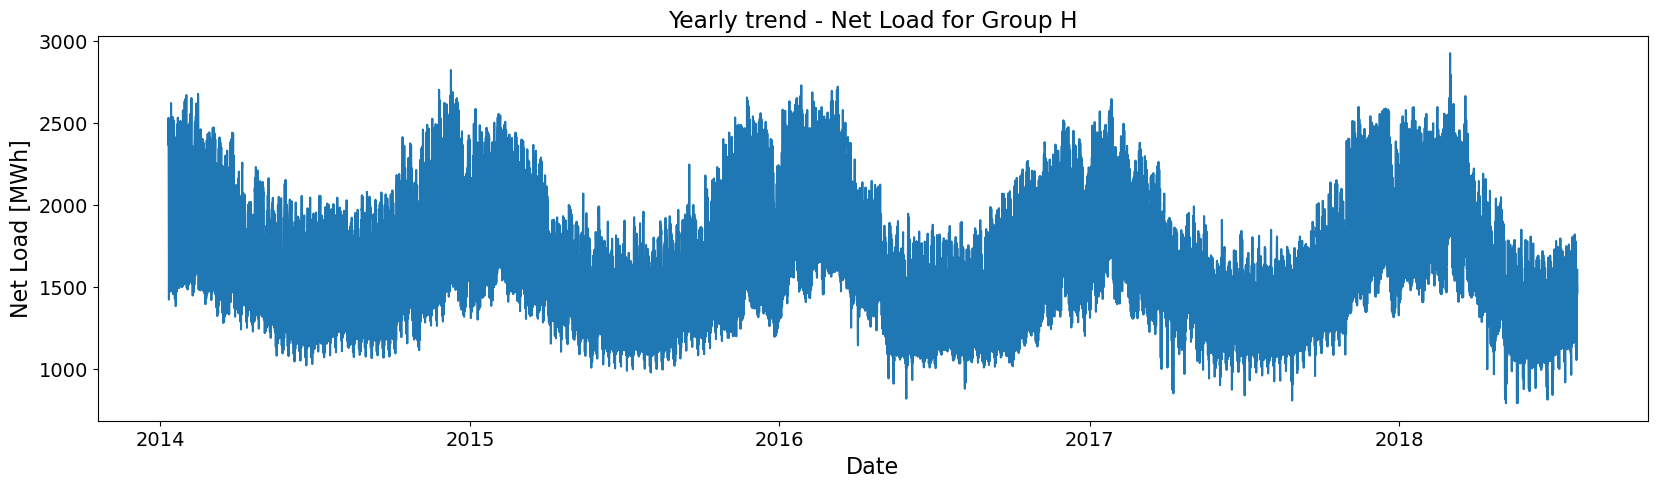

In [46]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,8))
plt.plot(GroupH_df["targetTime"][10466:10566], GroupH_df["node"][10466:10566], '-')
axs.set_title("Daily trend - Net Load for Group H")
plt.xticks(GroupH_df["targetTime"][10466:10566][::4], [date.strftime('%H:%M') for date in GroupH_df['targetTime'][10466:10566][::4]])
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize=16);
plt.ylabel("Net Load [MWh]", fontsize=16);
#plt.savefig("Figures/dailyH.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupH_df["targetTime"][10418:12482], GroupH_df["node"][10418:12482])
axs.set_title("Weekly trend - Net Load for Group H")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/weeklyH.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupH_df["targetTime"][400:80000:8], GroupH_df["node"][400:80000:8])

axs.set_title("Yearly trend - Net Load for Group H")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/yearlyH.jpg")

# Autocorrelation

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\3099180717.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\3099180717.py:11: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')


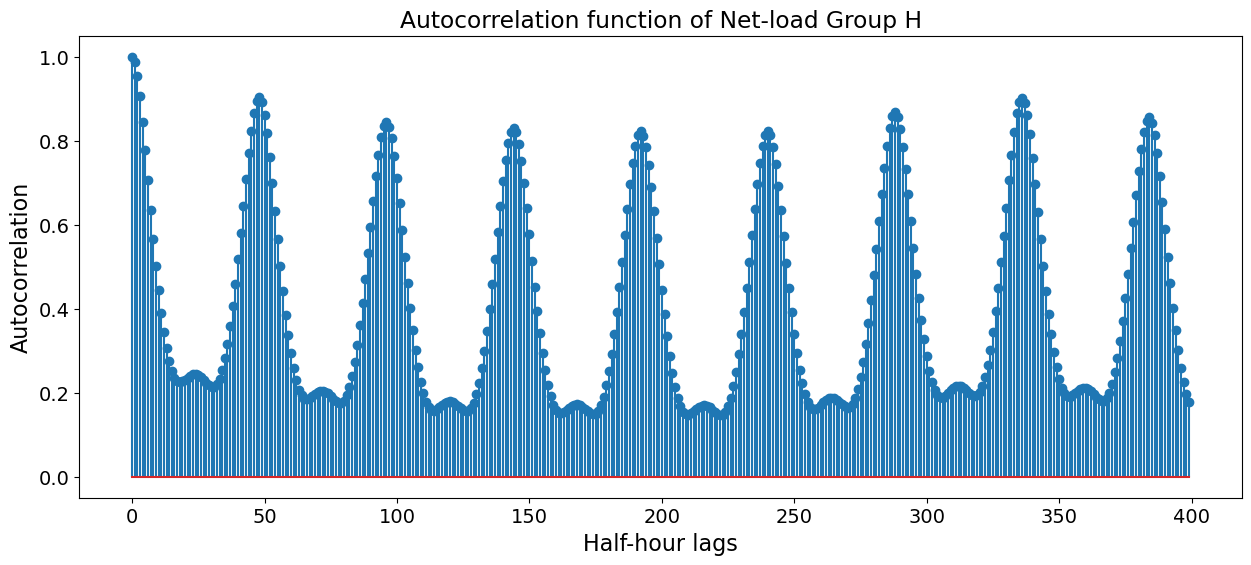

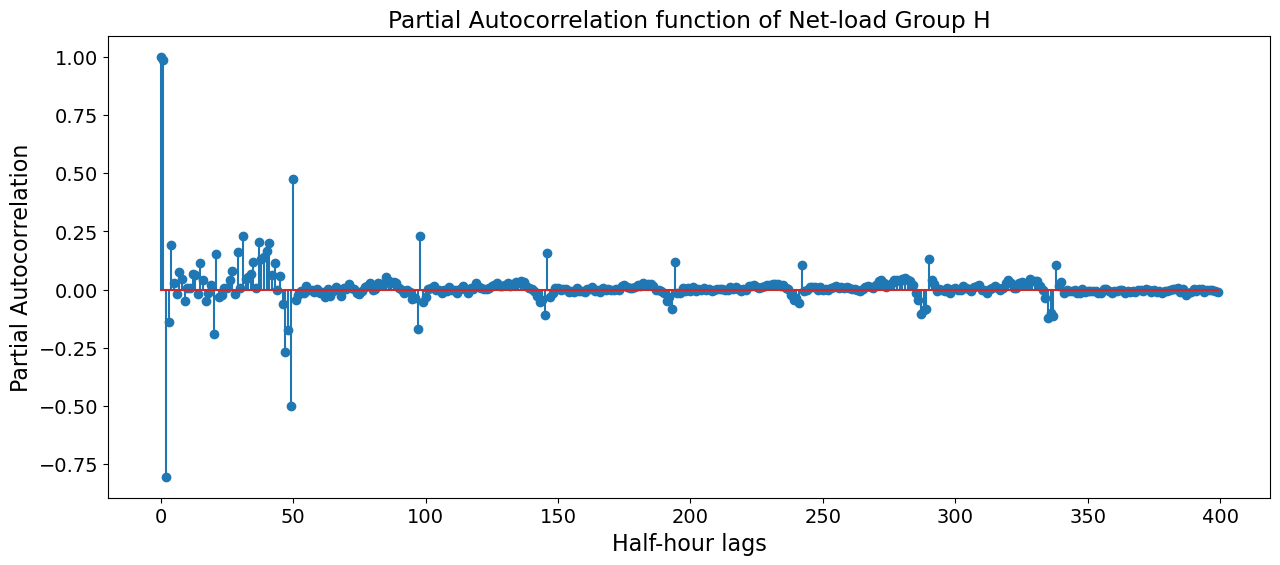

In [48]:
from statsmodels.tsa.stattools import pacf, acf
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,6))
plt.stem(range(400), acf(train_set["node"], nlags=399), 'o')
plt.title('Autocorrelation function of Net-load Group H');
plt.xlabel("Half-hour lags", fontsize=16);
plt.ylabel("Autocorrelation", fontsize=16);
#plt.savefig("Figures/AutocorrH.jpg")

plt.figure(figsize=(15,6))
plt.stem(range(400), pacf(train_set["node"], nlags=399), 'o')
plt.title('Partial Autocorrelation function of Net-load Group H');
plt.xlabel("Half-hour lags", fontsize=16);
plt.ylabel("Partial Autocorrelation", fontsize=16);
#plt.savefig("Figures/PartialAutocorrH.jpg")

# ADF test 

p-values of the ADF test for the 336 sub-series (one for each 30 minutes in 7 days) and of their differenced sub-series

In [51]:
p_value_336 = []
p_value_336_diff = []
for t in range(336):
    res = adfuller(np.array(train_set['node'])[t+144::336],regression='c',regresults=True)
    p_value_336.append(res[1])    
    y_336 = np.array(train_set['node'])[t+144::336]
    y_diff = y_336[1:]-y_336[:-1]
    res = adfuller(y_diff,regression='c',regresults=True)
    p_value_336_diff.append(res[1])


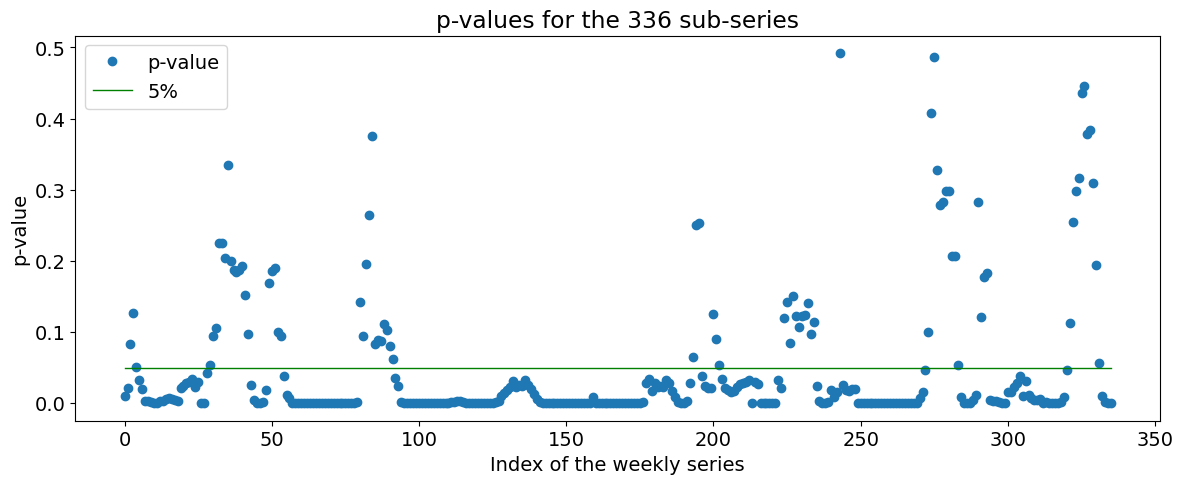

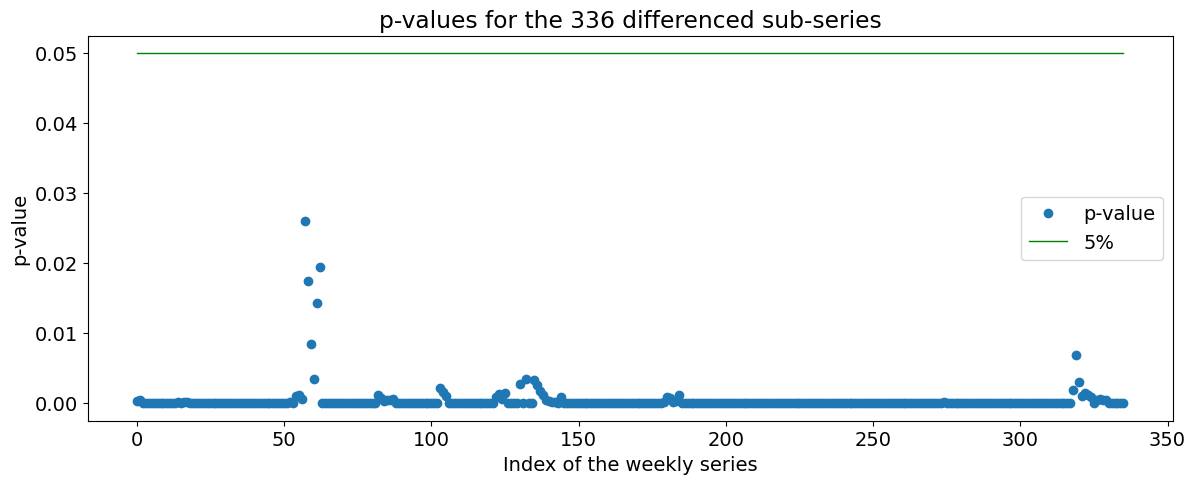

In [52]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_H.jpg")

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(14,5))
plt.plot(p_value_336_diff, 'o', label='p-value')
plt.plot(range(336), 0.05*np.ones(336,), color='green', linewidth=1, label='5%')
plt.xlabel("Index of the weekly series", fontsize=14)
plt.ylabel("p-value", fontsize=14)
plt.title('p-values for the 336 differenced sub-series')
plt.legend()
#plt.savefig("Figures/pval_weekly_7d_H.jpg")

# Autocorrelation differenced net-load time series 

C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\1172846702.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
C:\Users\Utente\AppData\Local\Temp\ipykernel_16840\1172846702.py:10: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')


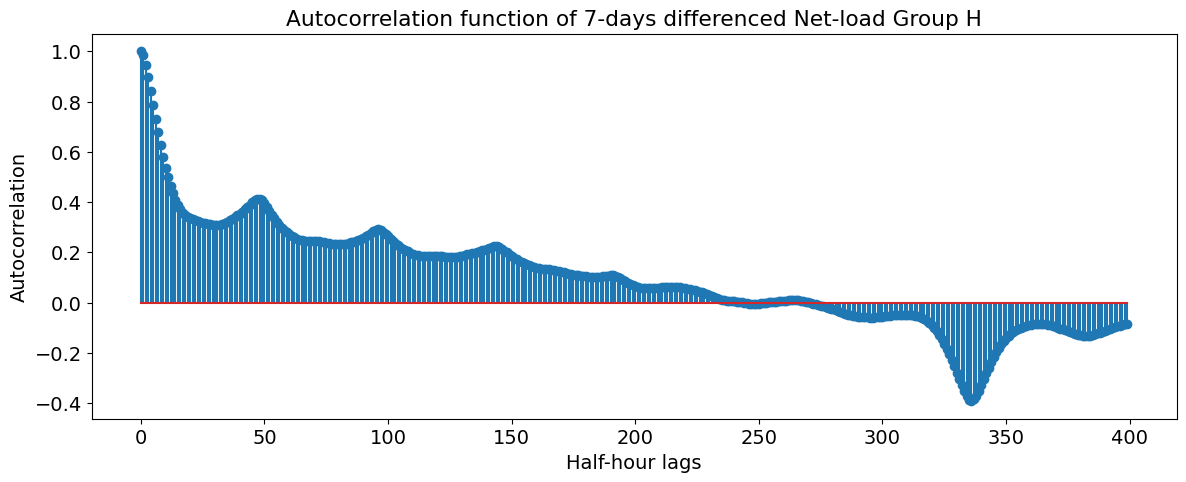

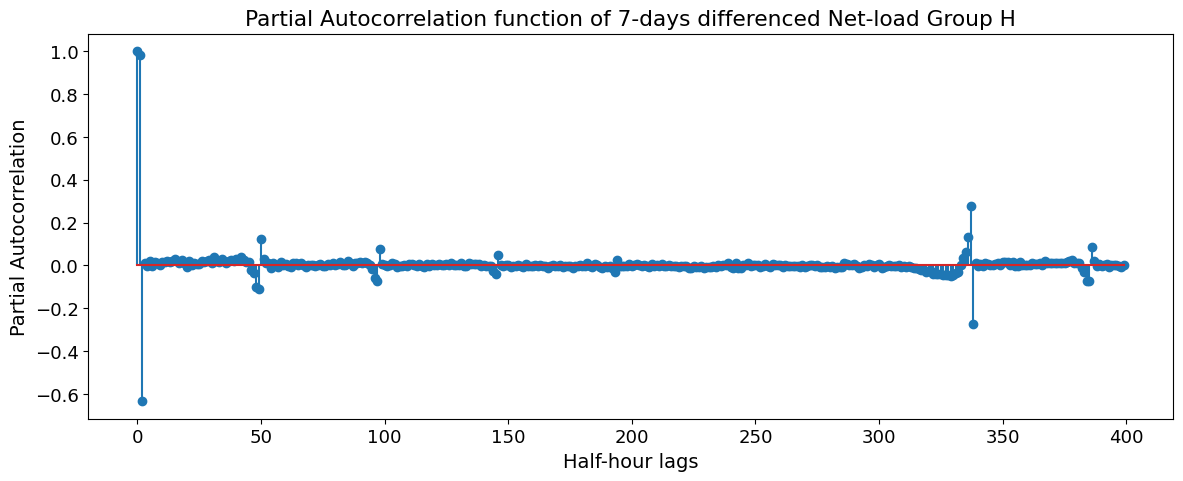

In [54]:
fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.rcParams.update({'font.size': 13})
plt.stem(range(400), acf(train_set["diff_336"], nlags=399), 'o')
plt.title('Autocorrelation function of 7-days differenced Net-load Group H');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Autocorrelation", fontsize=14);
#plt.savefig("Figures/AutocorrH_7diff.jpg")

fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.stem(range(400), pacf(train_set["diff_336"], nlags=399), 'o')
plt.title('Partial Autocorrelation function of 7-days differenced Net-load Group H');
plt.xlabel("Half-hour lags", fontsize=14);
plt.ylabel("Partial Autocorrelation", fontsize=14);
#plt.savefig("Figures/PartialAutocorrH_7diff.jpg")

# 7-days differenced net-load time series

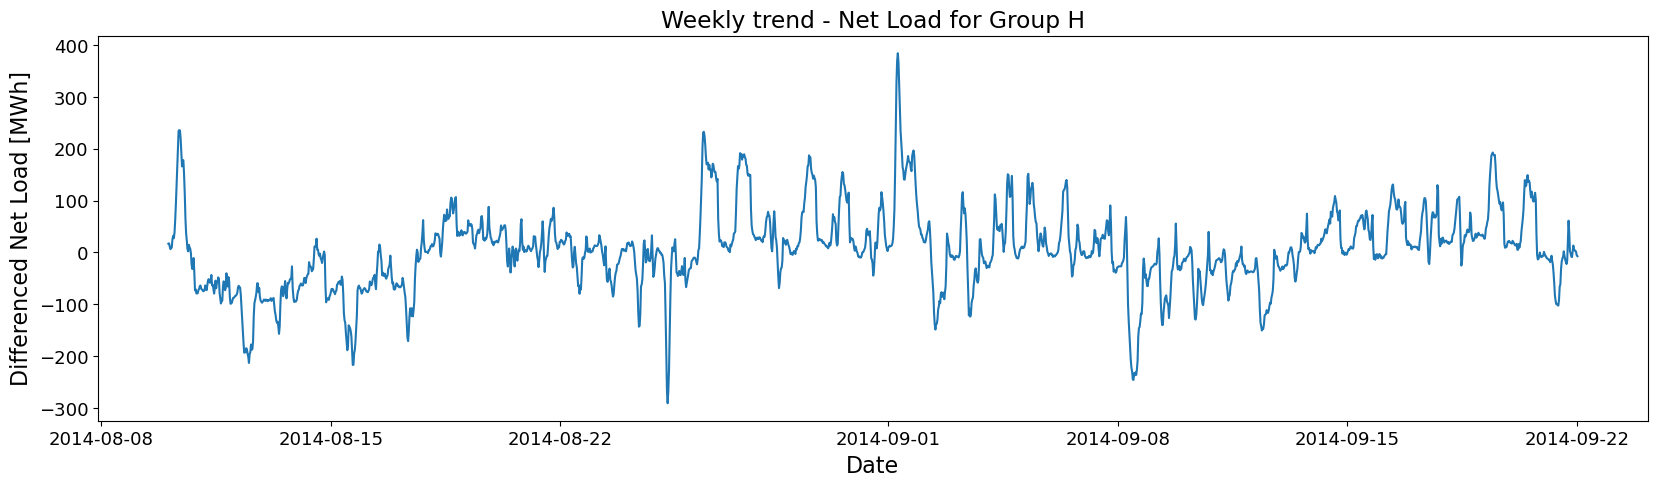

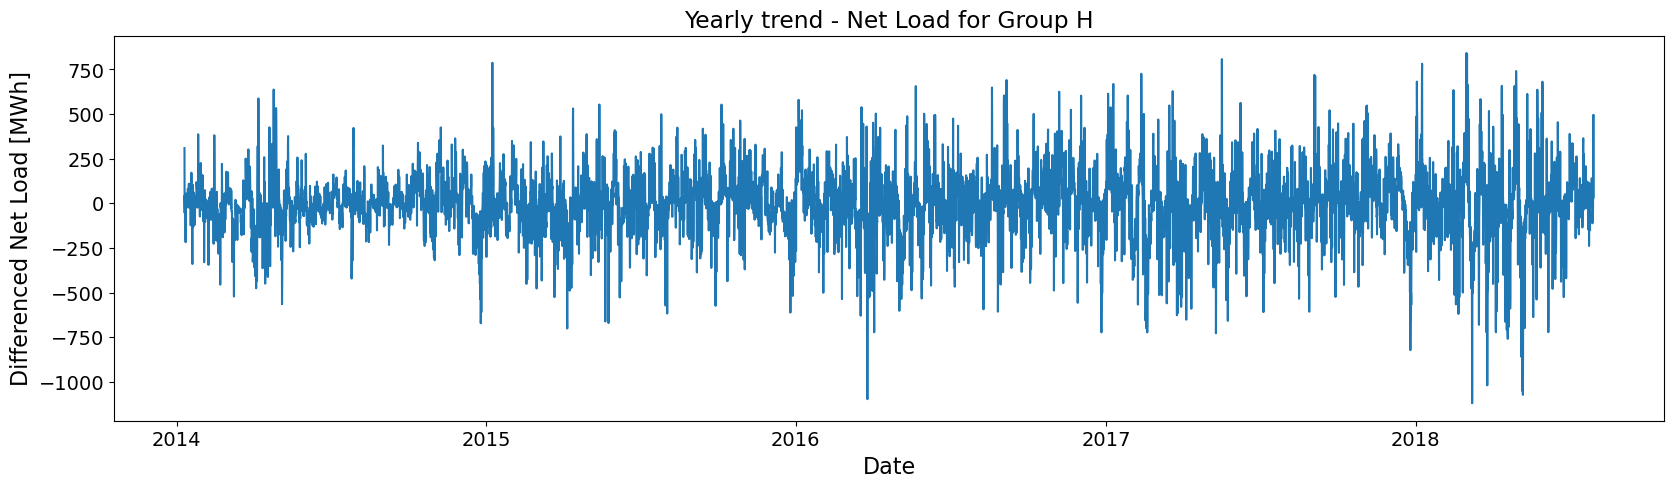

In [56]:
fig, axs = plt.subplots(1,1, figsize=(20,5))

plt.rcParams.update({'font.size': 14})
axs.plot(GroupH_df["targetTime"][10418:12482], GroupH_df["diff_336"][10418:12482])
axs.set_title("Weekly trend - Net Load for Group H")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_weeklyH.jpg")

fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(GroupH_df["targetTime"][400:80000:8], GroupH_df["diff_336"][400:80000:8])

axs.set_title("Yearly trend - Net Load for Group H")
axs.set_xlabel("Date", fontsize=16);
axs.set_ylabel("Differenced Net Load [MWh]", fontsize=16);
#fig.savefig("Figures/7diff_yearlyH.jpg")